# Multi-armed bandits

### Intro.

강화학습에서는 학습정보를 통해 올바른 action을 지시(instruct)하기보다는 선택가능한 action들에 대한 가치를 평가(evaluate)한다. 이것이 바로 강화학습을 다른 종류의 학습과 구분짓는 가장 중요한 특징이다. 이번 챕터에서는 일명 k-armed bandit problem이라고 불리는, 오직 하나의 state에서 독립된 k개의 action을 선택하는, 특수한 강화학습 문제를 살펴보도록 한다. 또한 이를 통해 몇 가지 solution methods를 살펴보도록 할 것이다.

### 2.1 k-armed bandit problem

'One-armed bandit'이라는 말을 들어본 적이 있는가? 단어 그대로 해석하면 '외팔이 강도'라는 뜻인데, 이는 도박용 슬롯머신의 생김새를 본따 비꼬아 표현한 말이다.

<img src="images/one-armed_bandit.png" alt="One-armed bandits" style="width: 600px;"/>
<center>[Fig. 2] Multi-armed bandit (<a href="https://www.google.co.kr/search?q=one-armed+bandit&tbm=isch">'one-armed bandit' searched by google</a>)</center>

그렇다면 k-armed bandit이란 무엇일까? 이는 마치 k개의 슬롯머신이 내 눈 앞에 있는 것과 같은 상황을 묘사한 문제라고 볼 수 있다. 

<img src="images/multi-armed_bandit.jpg" alt="Multi-armed bandits" style="width: 300px;"/>
<center>[Fig. 2] Multi-armed bandit (<a href="https://www.microsoft.com/en-us/research/">Microsoft research</a>)</center>

아주 간단한 형태의 k-armed bandit problem을 다음과 같이 정의해보자.

1. 매 time step마다 k개의 bandit machine 중에서 하나를 선택한다. 이는 매번 k개의 액션을 선택할 수 있는 것과 같다.
2. 선택된 bandit machine은 고정된 확률 분포(stationary probability distribution)를 통해 수치적인(numerical) reward를 반환한다.

우리의 목표는 위 절차를 어떤 time step만큼 반복하여 reward의 총합에 대한 기댓값이 가장 높은 bandit machine을 찾는 것이다. 시간이 흐르고 action을 반복하여 시행할수록, 우리는 점차 보상을 최대화 할 수 있으리라 여겨지는 action(the best lever)에 집중하게 될 것이다. 

참고로 오늘날의 'bandit problem'은 위의 예시 뿐만 아니라, action의 선택과 그에 대한 reward의 반환이 반복되는 문제를 총체적으로 일컫는다. 

앞서 정의한 k-armed bandit problem에서, t 시점에서 어떤 action을 선택했을때의 reward에 대한 기대값을 그 action에 대한 **value**라고 칭하고 다음과 같이 표현할 수 있다.
$$q_*(a) = E[R_t \phantom{1} | \phantom{1} A_t = a ].$$
* $R_t$: Reward on time step t, 
* $A_t$: Action on time step t

'보상을 최대화 할 수 있으리라 여겨지는 action에 집중한다.'는 말은 다른말로 action value가 가장 높은 action을 선택하겠다는 말과도 같다. 하지만 안타깝게도 대부분의 경우, 우리는 action value에 대한 정보를 사전에 가지고 있지 않을 것이다. 단지 실험을 반복하며 얻은 정보를 토대로 어떤 추정(estimate)을 할 수 있을 뿐이다. 여기서 그 추정을 $Q_t(a)$로 표현하도록 하자. $Q_t(a)$가 $q_*(a)$에 최대한 가까워진다면 객관적으로도 좋은 action을 선택할 수 있을 것이라 기대할 수 있다.

다음은 학습에서의 중요한 개념과 그에 대한 용어들을 살펴보도록 하자. Action value에 대한 추정함수 $Q_t(a)$에 대해, 매 time step에서 estimated value가 가장 높은 action이 최소한 한 개씩은 존재할 것이다. 우리는 이 action을 **greedy actions**라고 부르도록 한다. 또한 이 greedy actions 중 한가지 action을 선택하는 것을 **exploiting**이라고 한다. 한가지 유의해야 할 점은, 우리가 참고하는 $Q_t(a)$ 함수는 경험을 통한 추정치라는 것이다. 그렇기 때문에 $Q_t(a)$에 대한 신뢰도를 높이기 위해서는 때로 nongreedy actions 중 하나가 선택될 필요가 있다. 우리는 이것을 **exploring**이라고 부른다.
강화학습에서 exploitation과 exploration은 trade-off 관계에 해당한다. Exploring을 많이 하게되면 단기간 동안 받게되는 reward의 총량은 적어지겠지만, 장기적 관점에서 좋은 greedy actions를 발견하게 될 가능성이 커진다. 반면에 exploiting을 많이 하게되면 당장 받게되는 reward의 총량은 상대적으로 높아질 수 있지만, 장기적으로 현재의 greedy actions가 정말 객관적으로 좋은 actions에 해당하는지 확신하기 어려워진다. 이번 챕터에서는 k-armed bandit problem을 통해 exploitation과 exploration 사이에서 좋은 균형을 잡기위한 여러가지 방법들을 살펴보도록 하겠다. 이 주제는 강화학습에서 중점적으로 다루어지는 문제이기도 하다.

### 2.2 Action-value Methods

Action-value를 추정(estimate)하는 아주 간단한 방법에 대해 살펴보도록 하겠다. 자연스러운 접근으로는 선택한 action의 누적된 reward에 대해 평균을 내주는 방법이 있을 것이다. 이를 수식으로 표현하면 아래와 같다.
$$Q_t(a) = \frac{\text{sum of rewards when a taken prior to t}}{\text{number of times a taken prior to t}} = \frac{\Sigma_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i = a}}{\Sigma_{i=1}^{t-1} \mathbb{1}_{A_i = a}}$$

* $\mathbb{1}_{predicate}$: predicate이 true면 1을 반환하고, false면 0을 반환한다.
* 분모가 0인 경우에는 $Q_t(a)$을 임의의 상수값으로 정의한다. (가령, 0)

위 공식의 분모가 무한으로 발산하게 되면 $Q_t(a)$는 $q_*(a)$로 수렴하게 될 것이다. 이 방식을 우리는 **sample-average method**라고 부른다. 그렇다면 이 추정함수는 action을 선택(action selection)하는데 있어 어떻게 이용될 수 있을까? 가장 간단한 action selection 방식은 바로 가장 높은 추정치(estimated value)를 선정하는 것이다. 이것을 **greedy action selection**이라고 부른다.
$$A_t = argmax_a Q_t(a)$$

* $argmax_a Q_t(a)$ 함수는 $Q_t(a)$을 최대화시키는 action $a$를 반환한다.

항상 greedy action selection을 한다는 것은 항상 exploiting을 하는 것과도 같다. 즉, 이 방법만을 유지하게 되면 전체 actions의 가치에 대한 추정이 어느정도의 객관성을 보이기도 전에 특정 action만을 고집하게 될 수도 있을 것이다. 그렇기 때문에 가끔씩은 exploring을 통해 non-greedy action을 고를 필요가 있다. 이렇게 대부분의 경우 greedy action을 선택하면서 가끔씩은 non-greedy action을 선택하자는 아이디어가 바로 **$\epsilon$-greedy method**이다. 이 방법을 통해 매 time step마다 $1 - \epsilon$만큼의 확률로 greedy action selection을 하고, $\epsilon$ 만큼의 확률로는 non-greedy action selection을 한다. $\epsilon$-greedy method로 무한히 많은 action selection을 하게되면 결국 모든 action $a$에 대한 $Q_t(a)$는 $q_*(a)$에 수렴할 것이고, optimal action이 선택될 확률은 $1-\epsilon$에 가깝게 수렴할 것이다. 이해를 돕기 위해 아래의 연습문제를 살펴보자.

**Excercise**. 현재 $Q_t(a) = q_*(a)$를 만족하고, 10개의 action에 대해 $\epsilon = 0.1$로 $\epsilon$-greedy action selection을 하고 있다. 이때 optimal action이 선택될 확률은 어느정도 일까?

*solution:*
1. greedy action selection에 의해 $1 - \epsilon$의 확률로 optimal action이 선택된다: $1 - \epsilon$ = $1 - 0.1$ = 0.9
2. non-greedy action selection에 의해 $\epsilon$의 확률로 10개 중 임의의 action이 선택된다. 이 중 optimal action이 선택될 확률은: $0.1 * \frac{1}{10} = 0.01$

즉, optimal action이 선택될 확률은: $0.9 + 0.01 = 0.91$

### 2.3 The 10-armed Testbed

Greedy method와 $\epsilon$-greedy method의 성능비교를 위해 간단한 실험을 해보도록 하자. 이 실험에서는 2000개의 10-armed bandit 문제를 랜덤하게 생성하여 각 time step마다의 average reward와 optimal action selection을 그래프로 출력해보도록 할 것이다. 실험을 위한 설정은 다음과 같다.

1. 10개의 action에 대한 optimal action value($q_*(a), \text{ }a=1,\dotsc,10$)의 값을 mean=0, variance=1인 normal distribution으로 생성한다.
2. 각 action에 대한 time step t에서의 reward($R_t$)는 mean=$q_*(a)$, var=1의 normal distribution을 따른다고 가정한다.
3. 2000번의 독립적인 실험을 실시한다. 각 실험은 3000번의 time step동안 이루어진다.
4. 3을 $\epsilon$ = 0.1, 0.01, 0 (greedy)에 대해 각각 실시하고 이를 그래프로 출력한다.


Testbed 6 has the highest action value: 1.297206


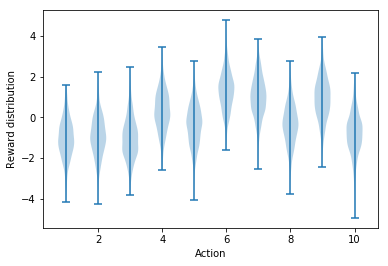

In [65]:
import numpy as np
import matplotlib.pyplot as plt

num_actions = 10 # the number of testbed
q_star = np.random.normal(0, 1, num_actions) # generate action values
optimal_action = np.argmax(q_star)
print('Testbed %d has the highest action value: %f' %(optimal_action+1, np.max(q_star)))

# print reward distribution for all testbeds
samples = []
for loc in q_star:
    samples.append(np.random.normal(loc, 1, 1000))
fig = plt.figure()
ax = plt.gca()
ax.violinplot(samples)
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.show()

In [66]:
from collections import defaultdict
import random

num_trials = 2000
num_time_steps = 3000
epsilons = [0, 0.01, 0.1]

rewards = np.zeros((len(epsilons), num_trials, num_time_steps))
action_selection = np.zeros((len(epsilons), num_trials, num_time_steps))

for i, epsilon in enumerate(epsilons):
    for j in range(num_trials):
        num_action_selected = np.zeros((num_actions))
        q_est = np.zeros((num_actions)) # Q_t(a)
        
        for k in range(num_time_steps):
            # idices of greedy actions and non-greedy actions
            greedy_actions = np.argwhere(q_est == np.amax(q_est)).flatten()
            nongreedy_actions = np.argwhere(q_est != np.amax(q_est)).flatten()
            
            # epsilon-greedy method
            action = None
            if random.random() <= 1 - epsilon or nongreedy_actions.shape[0] == 0:
                action = np.random.choice(greedy_actions)
            else:
                action = np.random.choice(nongreedy_actions)
                
            # reward from the normal distribution with mean = q_star(a) and std = 1
            reward = random.gauss(q_star[action], 1)
            
            # update Q_t(a)
            sum_rewards = 0
            sum_rewards += q_est[action] * num_action_selected[action] + reward
            num_action_selected[action] += 1
            q_est[action] = sum_rewards / num_action_selected[action]
            
            # update logs
            rewards[i][j][k] = reward
            action_selection[i][j][k] = action

average_reward = np.mean(rewards, axis=1)
ratio_optimal_action = np.mean((action_selection == optimal_action), axis=1)

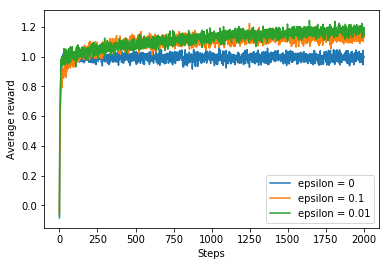

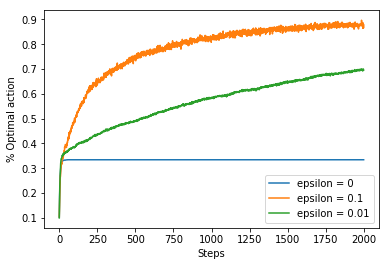

In [67]:
plt.figure(0)
for i, epsilon in enumerate(epsilons):
    plt.plot(average_reward[i], label='epsilon = '+str(epsilon))
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

plt.figure(1)
for i, epsilon in enumerate(epsilons):
    plt.plot(ratio_optimal_action[i], label='epsilon = '+str(epsilon))
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.show()

### References

1. Sutton, R. and Barto, A. (2017). *Reinforcement Learning: An Introduction*. 2nd ed. MIT Press